---
title: "Solvers"
format:
  html:
    embed-resources: true
    code-fold: true
    toc: true
---

## Notes

From the root directory, run "pip install -e ." in your current environment to download the package with the environment in order to wrap around gym and rllib. The information of the download is in setup.py.

## Versions and Dependencies

In [1]:
import ray
print(ray.__version__)

2.39.0


In [2]:
import subprocess

# Run the pip list command and print the output
installed_packages = subprocess.run(["pip", "list"], capture_output=True, text=True)
print(installed_packages.stdout)

Package                   Version     Editable project location
------------------------- ----------- ---------------------------------
absl-py                   2.1.0
aiosignal                 1.3.2
appnope                   0.1.4
asttokens                 3.0.0
attrs                     25.1.0
certifi                   2025.1.31
charset-normalizer        3.4.1
click                     8.1.8
cloudpickle               3.1.1
cmake                     3.31.4
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.12
decorator                 5.1.1
dm-tree                   0.1.9
exceptiongroup            1.2.2
executing                 2.1.0
Farama-Notifications      0.0.4
filelock                  3.17.0
fonttools                 4.56.0
frozenlist                1.5.0
fsspec                    2025.2.0
geosearch_package         0.1.0
gymnasium                 1.0.0
idna                      3.10
importlib_metadata  

## Libraries

In [3]:
import ray
from gymnasium.envs.registration import register
import gymnasium as gym
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.sac import SACConfig
from ray.rllib.algorithms.dqn import DQNConfig
import numpy as np
from ray import tune
from ray.rllib.algorithms.appo import APPOConfig
import matplotlib
import matplotlib.pyplot as plt
import torch
import pygame
from ray.rllib.models.torch.torch_action_dist import TorchCategorical
import os

In [4]:
# set up matplotlib interactive mode
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

In [5]:
from lunabot.geosearch import GeosearchEnv, Utils

## Load Environment

In [6]:
register(
    id="GeosearchEnv-v0",
    entry_point="geosearch_package.geosearch:GeosearchEnv",
)
env = GeosearchEnv()
#env = gym.make("GeosearchEnv-v0")
obs, info = env.reset()
print("Observation:", obs)

Observation: {'ring_heights': array([  1.6536138 ,   0.32882574,   1.1212595 ,   3.869373  ,
         7.878172  ,  -0.19372742,  -2.990011  ,  -4.2244167 ,
        -3.6551826 ,  -1.1473361 ,  -6.849477  , -10.955102  ,
       -14.098898  , -15.677522  , -14.618622  , -15.641657  ,
       -20.334412  , -24.958721  , -28.512442  , -28.866423  ,
       -22.87473   , -27.28802   , -32.878864  , -38.14657   ,
       -39.874302  ], dtype=float32), 'battery': array([87900.], dtype=float32), 'position': array([8., 8.], dtype=float32), 'sunlight': array([0.], dtype=float32), 'dust': array([0.23356521], dtype=float32), 'water_probs': array([0.97853915, 0.81797603, 0.4777797 , 0.19500222, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.81797603, 0.68375883, 0.39938345, 0.16300537, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.

## Helper functions to visualize training

In [7]:
def plot_metrics(rewards, lengths):
    fig = plt.figure(1, figsize=(16, 8))
    plt.clf()

    # plt.subplots(ncols=2, figsize=(12,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.set_title('Mean Rewards')
    ax1.set_xlabel('Evaluation Interval')
    ax1.set_ylabel('Mean Reward')
    ax1.plot(rewards)

    ax2.set_title('Mean Episode Length')
    ax2.set_xlabel('Evaluation Interval')
    ax2.set_ylabel('Episode Length')
    ax2.plot(lengths)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [8]:
# Define a generic policy wrapper class that works with all RLlib algorithms
class RLlibPolicyWrapper:
    def __init__(self, algo):
        self.algo = algo
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def process_state(self, state):
        # Convert dictionary observation to array
        state_array = np.concatenate([
            state['height'],
            state['battery'],
            state['position'],
            state['sunlight'],
            state['dust'],
            state['water_prob'],
            state['gold_prob']
        ])
        return state_array
        
    def get_action(self, state):
        # Get action from policy
        action = self.algo.compute_single_action(
            observation=state,
            explore=False  # Don't use exploration during visualization
        )
        return action

def visualize_policy(env, algo, algo_name="Algorithm", episodes=5, max_steps=50, save_gif=True, gif_dir="policy_gifs"):
    """
    Generic function to visualize any RLlib algorithm's policy.
    
    Args:
        env: The environment instance
        algo: The RLlib algorithm instance (PPO, SAC, DQN, or APPO)
        algo_name: Name of the algorithm for the output filename
        episodes: Number of episodes to run
        max_steps: Maximum steps per episode
        save_gif: Whether to save the visualization as a GIF
        gif_dir: Directory to save the GIFs (default: "policy_gifs")
    """
    try:
        # Initialize Pygame first
        pygame.init()
        
        # Create policy wrapper
        policy_wrapper = RLlibPolicyWrapper(algo)
        
        # Initialize visualization
        if env.render_mode != 'human':
            env.render_mode = 'human'
        env._init_render()
        
        frames = []
        total_reward = 0
        
        # Create directory for GIFs if it doesn't exist
        if save_gif:
            os.makedirs(gif_dir, exist_ok=True)
            gif_path = os.path.join(gif_dir, f"{algo_name.lower()}_policy.gif")
            print(f"GIF will be saved to: {gif_path}")
        
        for episode in range(episodes):
            state, info = env.reset()
            episode_reward = 0
            terminated = False
            steps = 0
            
            while not terminated and steps < max_steps:
                # Handle Pygame events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        raise KeyboardInterrupt
                
                # Render current state
                env.render()
                if save_gif:
                    frame = pygame.surfarray.array3d(env.screen)
                    frames.append(np.transpose(frame, (1, 0, 2)))
                
                # Get action from policy
                action = policy_wrapper.get_action(state)
                
                # Take action in environment
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                episode_reward += reward
                state = next_state
                steps += 1
                
                # Add small delay for visualization
                pygame.time.wait(66)  # ~15 FPS
                
            total_reward += episode_reward
            print(f"Episode {episode + 1} finished with reward: {episode_reward:.2f}")
        
        if save_gif and frames:
            Utils.create_gif(frames, filename=gif_path, duration=66)
            print(f"GIF saved successfully to {gif_path}")
        
        avg_reward = total_reward / episodes
        print(f"Average reward over {episodes} episodes: {avg_reward:.2f}")

    except KeyboardInterrupt:
        print("\nVisualization interrupted by user")
    
    except Exception as e:
        print(f"An error occurred during visualization: {str(e)}")
    
    finally:
        # Ensure proper cleanup
        if hasattr(env, 'close'):
            env.close()
        
        # Additional Pygame cleanup
        pygame.quit()
        print("Visualization completed and resources cleaned up")

In [9]:
# import torch
# import torch.nn as nn
# from ray.rllib.models import ModelCatalog
# from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
# # ResidualBlock

# # ======================
# # Custom Policy Model
# # ======================
# class CustomSACPolicyModel(TorchModelV2, nn.Module):
#     def __init__(self, obs_space, action_space, num_outputs, model_config, name, **kwargs):
#         # IMPORTANT: Call nn.Module.__init__() first.
#         nn.Module.__init__(self)
#         # Now call the TorchModelV2 initializer.
#         TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        
#         # Now it is safe to create module attributes.
#         self.non_image_size = 30  # 25 + 1 + 2 + 1 + 1
        
#         # 1) CNN for water_probs (35x35 grid)
#         self.conv_net = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Conv2d(16, 32, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Flatten()
#         )
        
#         # Calculate CNN output size.
#         with torch.no_grad():
#             dummy_conv = self.conv_net(torch.zeros(1, 1, 35, 35))
#             self.conv_out_size = dummy_conv.shape[1]

#         # 2) MLP for non-image features.
#         self.mlp = nn.Sequential(
#             nn.Linear(self.non_image_size, 128),
#             nn.ReLU(),
#             nn.Dropout(0.15),
#             #nn.LayerNorm(128),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Dropout(0.15),
#             #nn.LayerNorm(128)
#         )
        
#         # 3) Combined network.
#         self.combined_net = nn.Sequential(
#             nn.Linear(self.conv_out_size + 128, 256),
#             nn.ReLU()
#         )
        
#         # 4) Final logits layer (critical for SAC discrete).
#         self.logits = nn.Linear(256, num_outputs)

#     def forward(self, input_dict, state, seq_lens):
#         obs = input_dict["obs"]
        
#         # Process image input.
#         water_probs = obs["water_probs"].float().view(-1, 1, 35, 35)
#         conv_out = self.conv_net(water_probs)
        
#         # Process non-image features.
#         non_image = torch.cat([
#             obs["ring_heights"].float(),
#             obs["battery"].float(),
#             obs["position"].float(),
#             obs["sunlight"].float(),
#             obs["dust"].float()
#         ], dim=1)
#         mlp_out = self.mlp(non_image)
        
#         # Combine features.
#         combined = torch.cat([conv_out, mlp_out], dim=1)
#         features = self.combined_net(combined)
        
#         # Return logits directly (no value branch needed for the policy model).
#         return self.logits(features), state

# # Register the custom model.
# ModelCatalog.register_custom_model("custom_sac_model", CustomSACPolicyModel)


In [10]:
import torch
import torch.nn as nn
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models import ModelCatalog

# -------------------------------------------------------------------
# ResidualBlock and SkipConnection (unchanged)
# -------------------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + residual)

class SkipConnection(nn.Module):
    """
    Simple skip: x -> Linear -> ReLU -> + x -> out
    """
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.layer(x)
        out = self.relu(out)
        return out + x

# -------------------------------------------------------------------
# EnhancedModelNoPlateau with dynamic reshape for water_probs
# -------------------------------------------------------------------
class EnhancedModelNoPlateau(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name, **kwargs):
        nn.Module.__init__(self)
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)

        # 1) Convolutional stack with residual blocks
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),

            # For a 35x35 input, we eventually get down to 4x4 or so.
            # For a 15x15 input, it might be 3x3 or 2x2, depending on the stride.
            # We'll use AdaptiveAvgPool2d to unify the final size:
            nn.AdaptiveAvgPool2d((4, 4)),  # -> [B, 128, 4, 4] => Flatten => 2048
        )

        # 2) MLP for the other features (ring_heights=25, battery=1, position=2, sun=1, dust=1 => 30 dims)
        self.mlp = nn.Sequential(
            nn.Linear(30, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            SkipConnection(nn.Linear(256, 256)),  # skip block
            nn.Linear(256, 128),
            nn.ReLU(inplace=True)
        )

        # We'll produce ~2048 from the conv (128x4x4) plus 128 from MLP => 2176
        self.conv_out_size = 128 * 4 * 4
        combined_in = self.conv_out_size + 128

        self.combined = nn.Sequential(
            nn.Linear(combined_in, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_outputs)  # e.g. 6 discrete actions
        )

    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs"]

        # 1) Dynamically reshape water_probs => (B, 1, side, side)
        water_probs_flat = obs["water_probs"].float()   # shape [B, (H*W)]
        B, flatten_size = water_probs_flat.shape
        side = int(flatten_size ** 0.5)  # e.g., 15 or 35
        water_probs = water_probs_flat.view(B, 1, side, side)

        conv_feat = self.conv_net(water_probs)          # shape [B, 128, 4, 4] after adaptive pool
        conv_flat = conv_feat.view(conv_feat.size(0), -1)  # shape [B, 2048]

        # 2) MLP path for ring_heights(25), battery(1), position(2), sunlight(1), dust(1)
        non_image = torch.cat([
            obs["ring_heights"].float(),
            obs["battery"].float(),
            obs["position"].float(),
            obs["sunlight"].float(),
            obs["dust"].float()
        ], dim=1)  # shape [B, 30]
        mlp_out = self.mlp(non_image)    # shape [B, 128]

        # 3) Combine conv + mlp => final policy head
        combined_in = torch.cat([conv_flat, mlp_out], dim=1)  # shape ~ [B, 2176]
        trunk_intermediate = self.combined[:2](combined_in)    # linear->relu => [B, 512]
        logits = self.combined[2](trunk_intermediate)          # final linear => [B, num_actions]

        return logits, state

    def value_function(self):
        # Typically unused for discrete SAC, but RLlib might call it.
        return torch.zeros(1)
    
ModelCatalog.register_custom_model(
    "custom_sac_model", 
    EnhancedModelNoPlateau
)

## SAC

### Ray Instance

In [11]:
# from ray.rllib.algorithms.sac import SACConfig
# import numpy as np

# # ======================
# # Optimized SAC Configuration
# # ======================
# config = SACConfig()
# config.framework_str = "torch"
# config.env = GeosearchEnv

# # Core Algorithm Settings
# config.training(
#     # Network Architecture
#     policy_model_config={
#         "custom_model": "custom_sac_model",
#         "custom_action_dist": "categorical",
#         "conv_filters": [  # Enhanced CNN for spatial processing
#             [32, [4, 4], 2],
#             [64, [3, 3], 2],
#             [128, [3, 3], 1]
#         ],
#         "fcnet_hiddens": [512, 256],
#     },
#     q_model_config={
#         "fcnet_hiddens": [512, 512, 256],
#         "fcnet_activation": "swish",
#     },
#     lr=3e-4,
#     tau=0.005,
#     initial_alpha=0.2,
#     target_entropy="auto",
#     n_step=3,
#     train_batch_size=256,
#     # Switch to standard ReplayBuffer to avoid the beta issue.
#     replay_buffer_config={
#         "type": "ReplayBuffer",
#         "capacity": 100000,
#     }
# )

# # Environment Interaction
# config.rollout_fragment_length = 250
# config.num_workers = 8 # changed from 12 to 8
# config.evaluation_num_workers = 4 # changed just added it
# config.evaluation_interval = 50
# config.evaluation_duration = 30

# # Exploration & Optimization
# config.gamma = 0.99
# config.exploration_config = {
#     "type": "EpsilonGreedy",
#     "initial_epsilon": 0.9,  # or 0.1, tune as needed
#     "final_epsilon": 0.05,
#     "epsilon_timesteps": 50000,  # over how many timesteps to decay
# }

# # Experimental Features: Enable discrete SAC.
# config._enable_discrete_sac = True
# config.api_stack(
#     enable_rl_module_and_learner=False,
#     enable_env_runner_and_connector_v2=False
# )

# # Final Build
# algo = config.build()

In [12]:
from ray.rllib.algorithms.sac import SACConfig
import numpy as np

# ======================
# Updated SAC Configuration
# for a 15x15 Grid Environment
# ======================

config = SACConfig()
config.framework_str = "torch"
config.env = GeosearchEnv

# 2) Training settings
config.training(
    # Use your custom model (with residual blocks, skip connections, etc.).
    policy_model_config={
        "custom_model": "custom_sac_model",    # The enhanced model you registered
        "custom_action_dist": "categorical",
    },
    q_model_config={
        # These MLP layers are used internally for the Q networks in discrete SAC.
        "fcnet_hiddens": [512, 512, 256],
        "fcnet_activation": "swish",
    },
    lr=3e-4,                # Larger than your old 5e-5 for faster learning
    tau=0.005,
    initial_alpha=0.2,      # Entropy coefficient
    target_entropy="auto",
    n_step=3,               # Multi-step returns
    train_batch_size=256,   # Reduced batch size for smaller environment
    # Standard ReplayBuffer with capacity reduced for smaller state space
    replay_buffer_config={
        "type": "ReplayBuffer",
        "capacity": 100000,  # Could reduce further if memory is limited
    }
)

# 3) Environment interaction & rollout
config.rollout_fragment_length = 250
config.num_workers = 8                 # Parallel workers; can reduce if on smaller machine
config.evaluation_num_workers = 4
config.evaluation_interval = 50
config.evaluation_duration = 30

# 4) Discount, exploration
config.gamma = 0.99
config.exploration_config = {
    "type": "EpsilonGreedy",
    "initial_epsilon": 0.9,       # Start very high => strong exploration
    "final_epsilon": 0.05,        # Decay to 0.05
    "epsilon_timesteps": 20000,   # Decay over 20k timesteps (tune as needed)
}

# 5) Discrete SAC enablement (experimental)
config._enable_discrete_sac = True
# For RLlib versions 2.2+, you may need this if you're not using the new RLModule API:
config.api_stack(
    enable_rl_module_and_learner=False,
    enable_env_runner_and_connector_v2=False
)

# 6) Build the final algorithm
algo = config.build()


2025-02-12 21:36:43,628	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation_num_workers` has been deprecated. Use `AlgorithmConfig.evaluation_num_env_runners` instead. This will raise an error in the future!
/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:567: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interfa

(RolloutWorker pid=6507) [W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


### Training

In [13]:
rewards = []
lengths = []


Iteration 2900/3000
Time elapsed: 2.41 hours
Current reward: 3459.95
Best reward so far: 78613.96


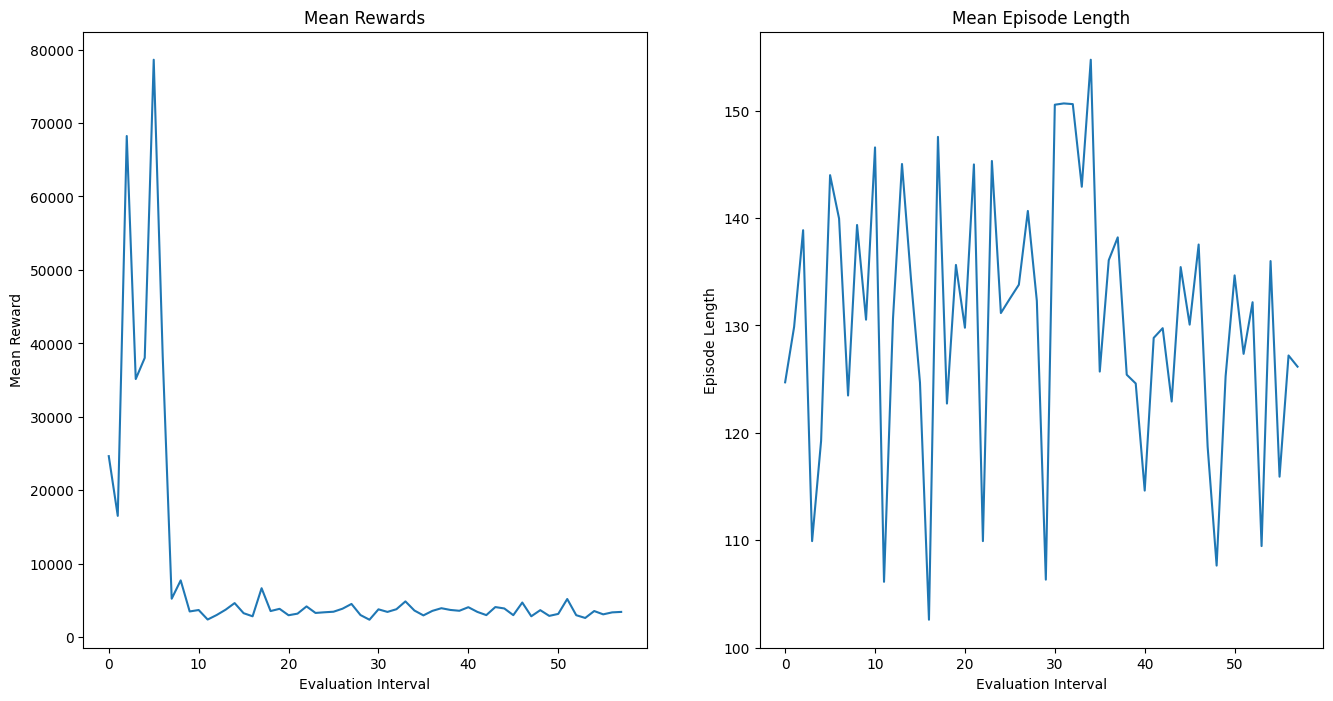

In [ ]:
import time

TRAINING_ITERATIONS = 3000
EVAL_INTERVAL = 50


# Modified training loop with better tracking
best_reward = float('-inf')
start_time = time.time()

for i in range(TRAINING_ITERATIONS):
    result = algo.train()
    
    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        current_reward = evaluation_results['env_runners']['episode_return_mean']
        rewards.append(current_reward)
        lengths.append(evaluation_results['env_runners']['episode_len_mean'])
        
        # Save best model
        if current_reward > best_reward:
            best_reward = current_reward
            checkpoint_dir = f"checkpoints/sac_lunar_best"
            algo.save(checkpoint_dir)
            
        # Print progress
        elapsed_time = (time.time() - start_time) / 3600  # in hours
        print(f"\nIteration {i+1}/{TRAINING_ITERATIONS}")
        print(f"Time elapsed: {elapsed_time:.2f} hours")
        print(f"Current reward: {current_reward:.2f}")
        print(f"Best reward so far: {best_reward:.2f}")
        
        plot_metrics(rewards, lengths)

## Model with auxiliary loss

In [ ]:
import torch
import torch.nn as nn
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2

# -------------------------------------------------------------------
# ResidualBlock and SkipConnection (unchanged)
# -------------------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + residual)

class SkipConnection(nn.Module):
    """
    Simple skip: x -> Linear -> ReLU -> + x -> out
    """
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.layer(x)
        out = self.relu(out)
        return out + x

# -------------------------------------------------------------------
# EnhancedModelWithAux (with dynamic reshape and auxiliary loss)
# -------------------------------------------------------------------
class EnhancedModelWithAux(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name, **kwargs):
        nn.Module.__init__(self)
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)

        # 1) Convolutional stack with residual blocks
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),

            # Adaptive pooling to handle different grid sizes (15x15 or 35x35)
            nn.AdaptiveAvgPool2d((4, 4)),  # -> [B, 128, 4, 4] => Flatten => 2048
        )

        # 2) MLP for the other features (ring_heights=25, battery=1, position=2, sun=1, dust=1 => 30 dims)
        self.mlp = nn.Sequential(
            nn.Linear(30, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            SkipConnection(nn.Linear(256, 256)),  # skip block
            nn.Linear(256, 128),
            nn.ReLU(inplace=True)
        )

        # We'll produce ~2048 from the conv (128x4x4) plus 128 from MLP => 2176
        self.conv_out_size = 128 * 4 * 4
        combined_in = self.conv_out_size + 128

        # 3) Combined network
        self.combined = nn.Sequential(
            nn.Linear(combined_in, 512),
            nn.LayerNorm(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True)
        )

        # 4) Output heads
        self.logits = nn.Linear(256, num_outputs)  # Policy logits
        self.water_predictor = nn.Linear(256, obs_space["water_probs"].shape[0])  # Auxiliary head for water prediction

    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs"]

        # 1) Dynamically reshape water_probs => (B, 1, side, side)
        water_probs_flat = obs["water_probs"].float()   # shape [B, (H*W)]
        B, flatten_size = water_probs_flat.shape
        side = int(flatten_size ** 0.5)  # e.g., 15 or 35
        water_probs = water_probs_flat.view(B, 1, side, side)

        conv_feat = self.conv_net(water_probs)          # shape [B, 128, 4, 4] after adaptive pool
        conv_flat = conv_feat.view(conv_feat.size(0), -1)  # shape [B, 2048]

        # 2) MLP path for ring_heights(25), battery(1), position(2), sunlight(1), dust(1)
        non_image = torch.cat([
            obs["ring_heights"].float(),
            obs["battery"].float(),
            obs["position"].float(),
            obs["sunlight"].float(),
            obs["dust"].float()
        ], dim=1)  # shape [B, 30]
        mlp_out = self.mlp(non_image)    # shape [B, 128]

        # 3) Combine conv + mlp => final policy head
        combined_in = torch.cat([conv_flat, mlp_out], dim=1)  # shape ~ [B, 2176]
        features = self.combined(combined_in)  # shape [B, 256]

        # 4) Compute outputs
        logits = self.logits(features)  # Policy logits
        water_pred = self.water_predictor(features)  # Auxiliary prediction

        # Store auxiliary prediction for loss calculation
        self._auxiliary_output = water_pred

        return logits, state

    def auxiliary_loss(self, true_water_probs):
        """Compute the auxiliary loss for water probability prediction."""
        return F.mse_loss(self._auxiliary_output, true_water_probs)

    def value_function(self):
        # Typically unused for discrete SAC, but RLlib might call it.
        return torch.zeros(1)
    
from ray.rllib.models import ModelCatalog

ModelCatalog.register_custom_model("enhanced_model_with_aux", EnhancedModelWithAux)

def custom_loss(policy, model, dist_class, train_batch):
    # Standard SAC loss
    sac_loss = policy.loss_fn(policy, model, dist_class, train_batch)
    
    # Auxiliary loss for water prediction
    true_water_probs = train_batch["obs"]["water_probs"]
    aux_loss = model.auxiliary_loss(true_water_probs)
    
    # Combine losses
    total_loss = sac_loss + 0.1 * aux_loss  # Weighted auxiliary loss
    return total_loss

from ray.rllib.algorithms.sac import SACConfig
from ray.rllib.algorithms.sac.sac_torch_model import SACTorchModel
import torch.nn.functional as F

# ======================
# Custom Loss Function
# ======================
def custom_sac_loss(policy, model, dist_class, train_batch):
    # 1) Standard SAC loss components
    sac_loss_dict = SACTorchModel.loss(policy, model, dist_class, train_batch)
    
    # 2) Auxiliary loss for water probability prediction
    true_water_probs = train_batch["obs"]["water_probs"]
    aux_loss = model.auxiliary_loss(true_water_probs)
    
    # 3) Combine losses with weighting factor (0.1 is a hyperparameter)
    total_loss = sac_loss_dict["total_loss"] + 0.1 * aux_loss
    
    # 4) Return modified loss dictionary
    return {
        **sac_loss_dict,
        "total_loss": total_loss,
        "auxiliary_loss": aux_loss,
    }

# ======================
# Updated SAC Configuration
# ======================
config = SACConfig()
config.framework_str = "torch"
config.env = GeosearchEnv

# Training settings with custom loss
config.training(
    # Existing settings...
    _enable_learner_api=False,  # Required for custom loss functions
    _disable_execution_plan_api=True,
)

# Add custom loss to the configuration
config.training(
    model={
        "custom_model": "custom_sac_model",
        "custom_action_dist": "categorical",
        "custom_loss": custom_sac_loss,  # Register custom loss
    },
    # Keep other training settings unchanged...
)

# Rest of your existing config...
config.q_model_config={
    "fcnet_hiddens": [512, 512, 256],
    "fcnet_activation": "swish",
},
config.lr=3e-4,
config.tau=0.005,
config.initial_alpha=0.2,
config.target_entropy="auto",
config.n_step=3,
config.train_batch_size=256,
config.replay_buffer_config={
    "type": "ReplayBuffer",
    "capacity": 100000,
},
config.rollout_fragment_length = 250,
config.num_workers = 8,
config.evaluation_num_workers = 4,
config.evaluation_interval = 50,
config.evaluation_duration = 30,
config.gamma = 0.99,
config.exploration_config = {
    "type": "EpsilonGreedy",
    "initial_epsilon": 0.9,
    "final_epsilon": 0.05,
    "epsilon_timesteps": 20000,
},
config._enable_discrete_sac = True,
config.api_stack(
    enable_rl_module_and_learner=False,
    enable_env_runner_and_connector_v2=False
)

# Build the final algorithm
algo = config.build()

### Save the weights:

In [ ]:
#policy = algo.get_policy()
weights = algo.get_weights()

### Visualize how the algorithm performs:

In [ ]:
# For SAC
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="skip_Policy_15grid", episodes=3, max_steps=365)

GIF will be saved to: policy_gifs/try_gathering_encourage_policy.gif
Episode 1 finished with reward: 5778.00
Episode 2 finished with reward: 4849.09
Episode 3 finished with reward: 4244.00
Gameplay GIF saved as policy_gifs/try_gathering_encourage_policy.gif
GIF saved successfully to policy_gifs/try_gathering_encourage_policy.gif
Average reward over 3 episodes: 4957.03
Visualization completed and resources cleaned up


*** SIGTERM received at time=1739375994 ***
PC: @     0x7ff81469672e  (unknown)  kevent
    @        0x1172ff604  (unknown)  absl::lts_20230125::WriteFailureInfo()
    @        0x1172ff36b  (unknown)  absl::lts_20230125::AbslFailureSignalHandler()
    @     0x7ff8146fe37d  (unknown)  _sigtramp
    @     0x7fcc9070d450  (unknown)  0x0
    @        0x102d78fbe  (unknown)  method_vectorcall_FASTCALL
    @        0x102e88c37  (unknown)  _PyEval_EvalFrameDefault
    @        0x102d69290  (unknown)  _PyFunction_Vectorcall
    @        0x102e88c37  (unknown)  _PyEval_EvalFrameDefault
    @        0x102d69290  (unknown)  _PyFunction_Vectorcall
    @        0x102e88c37  (unknown)  _PyEval_EvalFrameDefault
    @        0x102d69290  (unknown)  _PyFunction_Vectorcall
    @        0x102e88c37  (unknown)  _PyEval_EvalFrameDefault
    @        0x102d69290  (unknown)  _PyFunction_Vectorcall
    @        0x102e88c37  (unknown)  _PyEval_EvalFrameDefault
    @        0x102d69290  (unknown)  _PyFunction_V

## PPO

### Ray Instance

In [ ]:
#from ray.rllib.algorithms.ppo import PPOConfig
config = PPOConfig()
config.framework_str = "torch"
config.env = GeosearchEnv
config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)
config.num_workers = 4
config.evaluation_interval = 50
config.evaluation_num_workers = 2

algo = config.build()


2024-12-08 15:51:52,779	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation_num_workers` has been deprecated. Use `AlgorithmConfig.evaluation_num_env_runners` instead. This will raise an error in the future!
/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:567: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json

### Training

In [ ]:
rewards = []
lengths = []

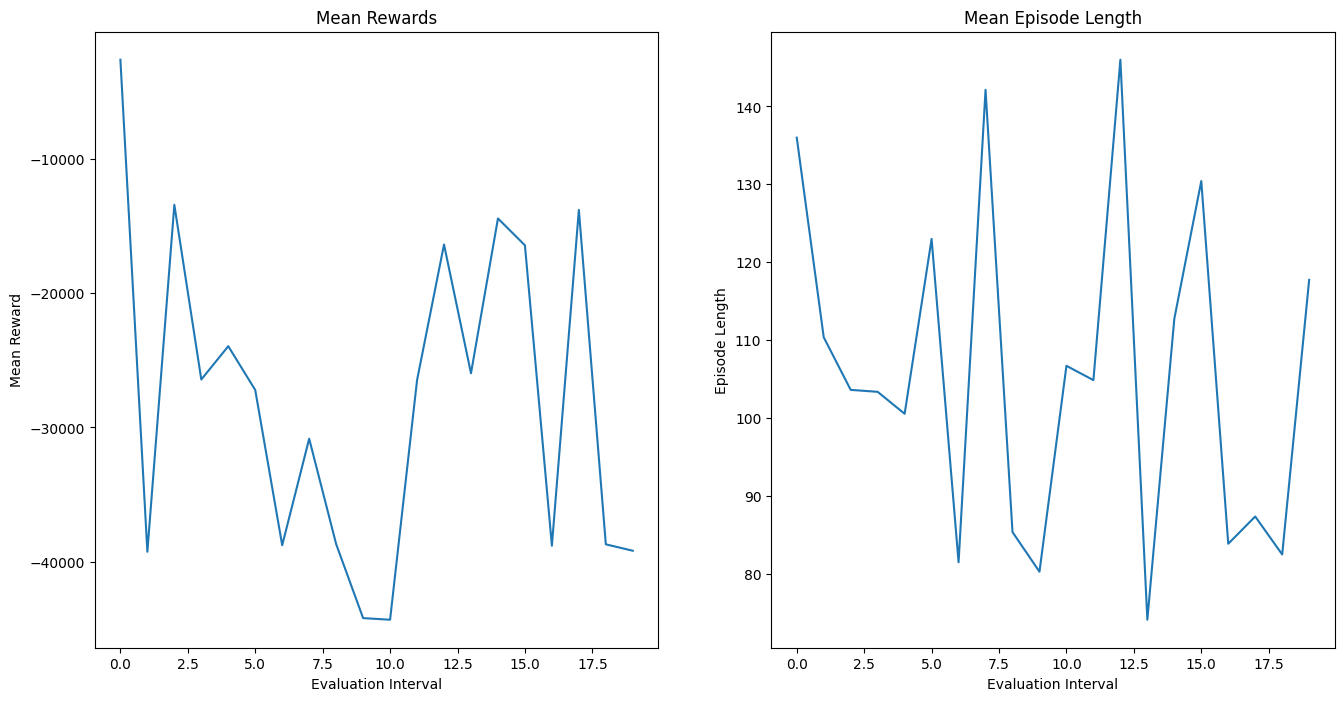

In [ ]:
TRAINING_ITERATIONS = 1000
EVAL_INTERVAL = 50


for i in range(TRAINING_ITERATIONS):
    
    algo.train()

    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        rewards.append(evaluation_results['env_runners']['episode_return_mean'])
        lengths.append(evaluation_results['env_runners']['episode_len_mean'])
        plot_metrics(rewards, lengths)

### Saving the weights:

In [ ]:
#policy = algo.get_policy()
weights = algo.get_weights()

### Visualize how the algorithm performs:

In [ ]:
# For PPO
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="PPO", episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/ppo_policy.gif


2024-12-08 17:01:39.767 python[31705:1541050] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-08 17:01:39.767 python[31705:1541050] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Episode 1 finished with reward: -1105.00
Episode 2 finished with reward: -100669.00
Episode 3 finished with reward: -101930.00
Gameplay GIF saved as policy_gifs/ppo_policy.gif
GIF saved successfully to policy_gifs/ppo_policy.gif
Average reward over 3 episodes: -67901.33
Visualization completed and resources cleaned up


## DQN/Rainbow

### Ray Instance

In [19]:
config = DQNConfig()
config.framework_str = "torch"
config.env = GeosearchEnv
config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)
config.num_workers = 4
config.evaluation_interval = 50
config.evaluation_num_workers = 2
config.training(
    replay_buffer_config={
        "type": "MultiAgentReplayBuffer",
        "capacity": 10000,  # Adjust as needed
        # If you want prioritized replay:
        # "type": "MultiAgentPrioritizedReplayBuffer",
        # "prioritized_replay_alpha": 0.6,
        # "prioritized_replay_beta": 0.4,
        # "prioritized_replay_eps": 1e-6,
    }
)

algo = config.build()

2024-12-08 18:08:44,803	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation_num_workers` has been deprecated. Use `AlgorithmConfig.evaluation_num_env_runners` instead. This will raise an error in the future!
2024-12-08 18:08:47,447	WARNING util.py:61 -- Install gputil for GPU system monitoring.


### Training

In [20]:
rewards = []
lengths = []

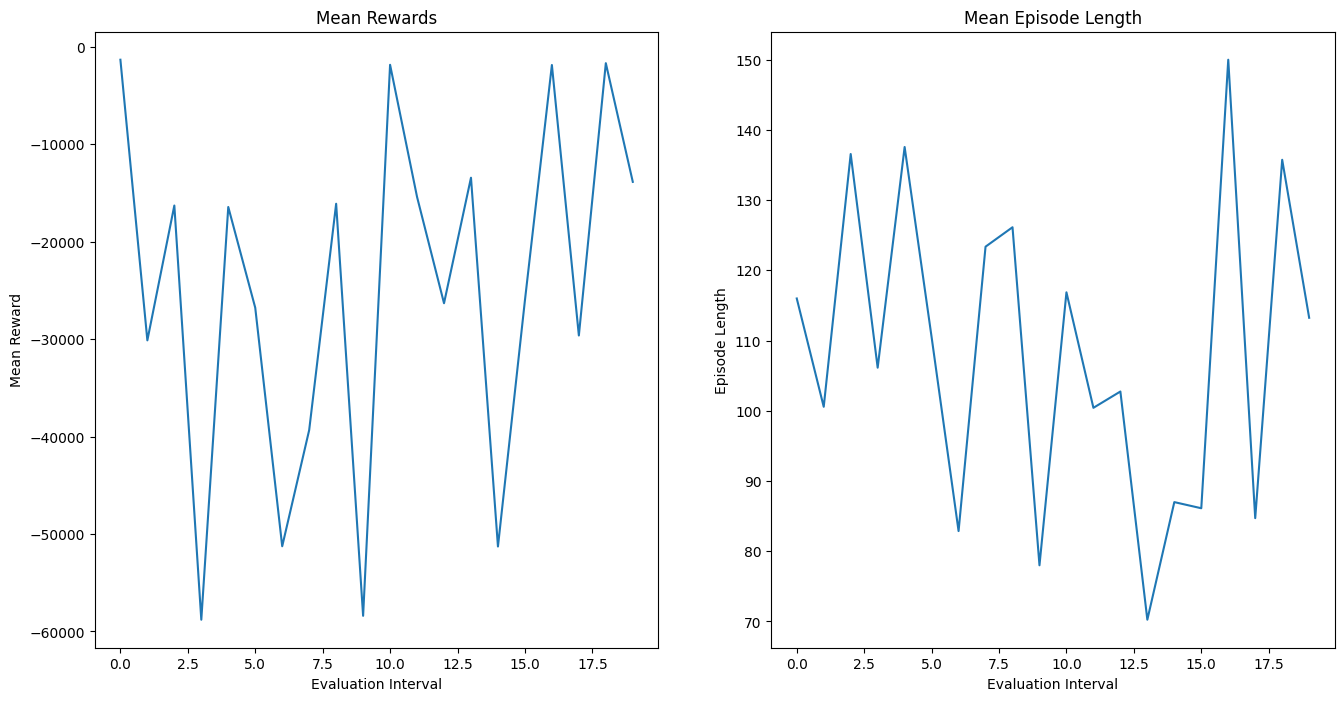

In [21]:
TRAINING_ITERATIONS = 1000
EVAL_INTERVAL = 50

for i in range(TRAINING_ITERATIONS):
    
    algo.train()

    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        rewards.append(evaluation_results['env_runners']['episode_return_mean'])
        lengths.append(evaluation_results['env_runners']['episode_len_mean'])
        plot_metrics(rewards, lengths)
     

### Save the weights:

In [22]:
#policy = algo.get_policy()
weights = algo.get_weights()

### Visualize how the algorithm performs:

In [23]:
# For DQN
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="DQN", episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/dqn_policy.gif
Episode 1 finished with reward: -1230.00
Episode 2 finished with reward: -1265.00
Episode 3 finished with reward: -870.00
Gameplay GIF saved as policy_gifs/dqn_policy.gif
GIF saved successfully to policy_gifs/dqn_policy.gif
Average reward over 3 episodes: -1121.67
Visualization completed and resources cleaned up


## APPO

### Ray Instance and wrapping environment

In [24]:
# Initialize Ray
ray.init(ignore_reinit_error=True)

# Define the custom observation wrapper
class NoLimitObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        if isinstance(env.observation_space, gym.spaces.Dict):
            new_spaces = {}
            for key, space in env.observation_space.spaces.items():
                if isinstance(space, gym.spaces.Box):
                    shape = space.shape
                    new_spaces[key] = gym.spaces.Box(
                        low=-np.inf, high=np.inf, shape=shape, dtype=np.float32
                    )
                else:
                    # If there are other space types, handle them as needed
                    new_spaces[key] = space
            self.observation_space = gym.spaces.Dict(new_spaces)
        else:
            # If it's a single Box space
            shape = env.observation_space.shape
            self.observation_space = gym.spaces.Box(
                low=-np.inf, high=np.inf, shape=shape, dtype=np.float32
            )
    
    def observation(self, observation):
        return observation


# Define the environment creator function
def env_creator(env_config):
    env = GeosearchEnv()  # Directly instantiate the environment class
    env = NoLimitObservationWrapper(env)
    return env

# Register the custom environment
tune.register_env("NoLimitGeosearchEnv", env_creator)

# Configure APPO with the custom environment
config = APPOConfig()
config = config.environment(env="NoLimitGeosearchEnv", disable_env_checking=True)
config = config.framework("torch")
config = config.rollouts(num_env_runners=4)
config = config.evaluation(evaluation_num_workers=2, evaluation_interval=50)

# Build the algorithm
algo = config.build()


2024-12-08 20:29:55,293	INFO worker.py:1652 -- Calling ray.init() again after it has already been called.
2024-12-08 20:29:55,296	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!
2024-12-08 20:29:55,296	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation(evaluation_num_workers=..)` has been deprecated. Use `AlgorithmConfig.evaluation(evaluation_num_env_runners=..)` instead. This will raise an error in the future!
2024-12-08 20:30:00,435	WARNING util.py:61 -- Install gputil for GPU system monitoring.


### Training

In [25]:
rewards = []
lengths = []

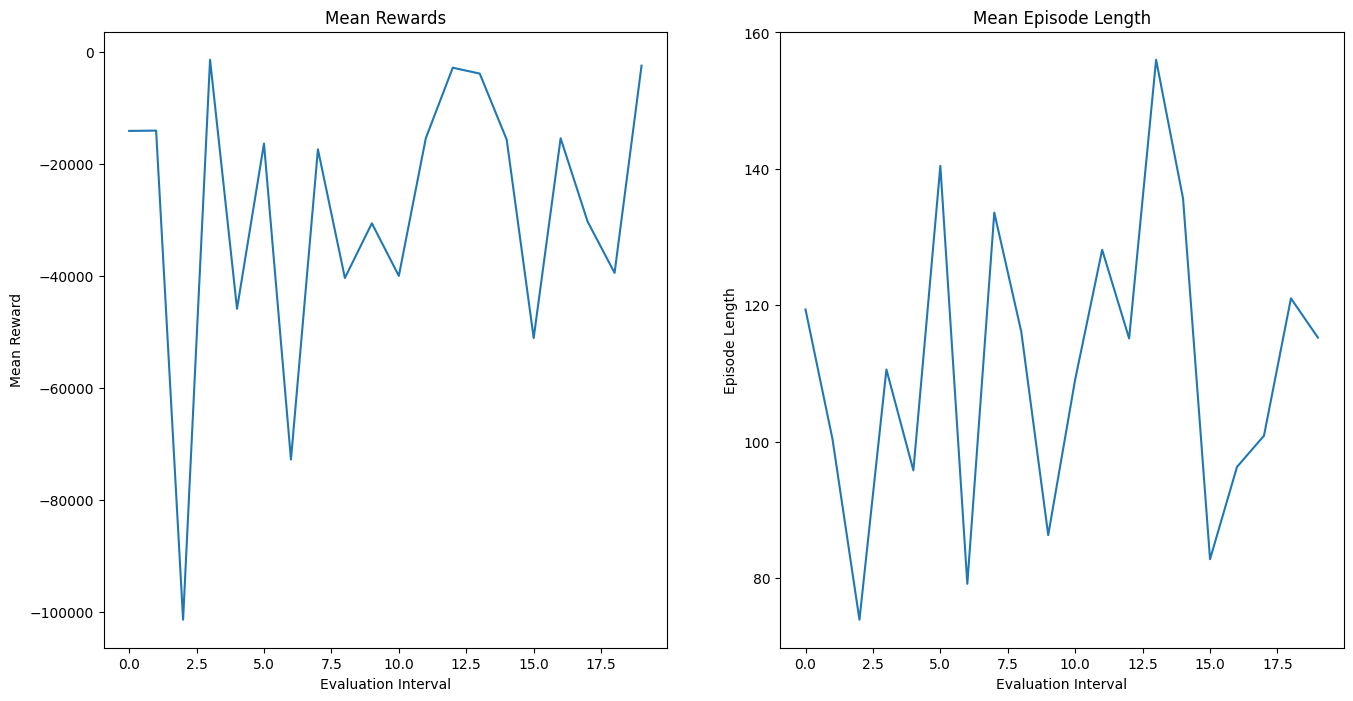

In [26]:
TRAINING_ITERATIONS = 1000
EVAL_INTERVAL = 50


for i in range(TRAINING_ITERATIONS):
    result = algo.train()
    
    # Access the mean episode reward and length from 'env_runners'
    mean_reward = result['env_runners']['episode_reward_mean']
    mean_length = result['env_runners']['episode_len_mean']
    
    print(f"Iteration {i+1}: episode_reward_mean = {mean_reward}, episode_len_mean = {mean_length}")

    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        eval_mean_reward = evaluation_results['env_runners']['episode_reward_mean']
        eval_mean_length = evaluation_results['env_runners']['episode_len_mean']
        rewards.append(eval_mean_reward)
        lengths.append(eval_mean_length)
        plot_metrics(rewards, lengths)

### Save the weights:

In [27]:
# For APPO
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="APPO", episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/appo_policy.gif
Episode 1 finished with reward: -2250.00
Episode 2 finished with reward: -1676.00
Episode 3 finished with reward: -1920.00
Gameplay GIF saved as policy_gifs/appo_policy.gif
GIF saved successfully to policy_gifs/appo_policy.gif
Average reward over 3 episodes: -1948.67
Visualization completed and resources cleaned up


### Visualize how the algorithm performs:

In [ ]:
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/algorithm_policy.gif
Episode 1 finished with reward: -2130.00
Episode 2 finished with reward: -2100.00


Exception in thread Thread-14:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 76, in run
    self.step()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 149, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 51, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty


Episode 3 finished with reward: -2820.00
Gameplay GIF saved as policy_gifs/algorithm_policy.gif
GIF saved successfully to policy_gifs/algorithm_policy.gif
Average reward over 3 episodes: -2350.00
Visualization completed and resources cleaned up


: 